In [1]:
!pip install fastai==0.7.0 --no-deps
!pip install torch==0.4.1 torchvision==0.2.1

    100% |████████████████████████████████| 122kB 3.7MB/s ta 0:00:01
  Found existing installation: fastai 1.0.36.post1
    Uninstalling fastai-1.0.36.post1:
      Successfully uninstalled fastai-1.0.36.post1
    100% |████████████████████████████████| 519.5MB 77kB/s  eta 0:00:01  9% |███                             | 47.4MB 35.2MB/s eta 0:00:14    20% |██████▋                         | 108.1MB 35.4MB/s eta 0:00:12    26% |████████▍                       | 135.6MB 34.8MB/s eta 0:00:12    30% |█████████▊                      | 157.6MB 36.2MB/s eta 0:00:10165.2MB 13.1MB/s eta 0:00:28    31% |██████████▎                     | 166.2MB 6.8MB/s eta 0:00:52    32% |██████████▌                     | 169.9MB 31.2MB/s eta 0:00:12    33% |██████████▋                     | 173.1MB 32.2MB/s eta 0:00:11�█████▍                    | 184.8MB 46.5MB/s eta 0:00:08    45% |██████████████▋                 | 236.9MB 35.9MB/s eta 0:00:08    50% |████████████████▎               | 263.8MB 34.7MB/s eta 0:00:08 

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.imports import *
from fastai.torch_imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

torch.cuda.set_device(0)

In [3]:
PATH = "../input"
sz=224

In [4]:
os.listdir(PATH)

['train', 'test', 'meta', 'Meta.csv', 'Train.csv', 'Test.csv']

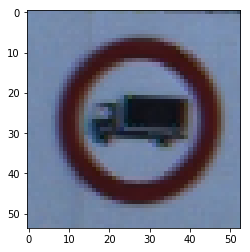

In [5]:
img = plt.imread(f'{PATH}/test/00000.png')
plt.imshow(img);

In [6]:
img.shape

(54, 53, 3)

In [7]:
import pathlib
arch=resnet34
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz), val_name='train')# using training data as validation data, cause we have samller dataset.
data.path = pathlib.Path('.')
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.01, 4)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /tmp/.torch/models/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:01<00:00, 77213929.05it/s]


  0%|          | 0/613 [00:00<?, ?it/s]

/opt/conda/lib/python3.6/site-packages/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)
/opt/conda/lib/python3.6/site-packages/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)


100%|██████████| 613/613 [03:42<00:00,  3.65it/s]


epoch      trn_loss   val_loss   accuracy                    
    0      0.945837   0.549731   0.839629  
    1      0.710909   0.379389   0.891198                    
    2      0.630784   0.300572   0.912316                    
    3      0.549956   0.246139   0.931903                    



[0.24613874339513758, 0.93190338948991]

In [8]:
lrf=learn.lr_find() # to find a good learning rate

 79%|███████▉  | 484/613 [00:08<00:02, 62.42it/s, loss=1.96] 


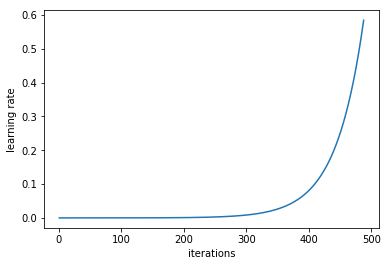

In [9]:
learn.sched.plot_lr()

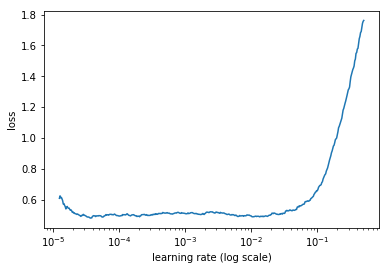

In [10]:
learn.sched.plot()

Trying to improve with data augmentation

In [11]:
tfms = tfms_from_model(resnet101, sz, aug_tfms=transforms_side_on)
data = ImageClassifierData.from_paths(PATH, tfms=tfms, num_workers=1, val_name='train')
data.path = pathlib.Path('.')

In [12]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

/opt/conda/lib/python3.6/site-packages/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)
/opt/conda/lib/python3.6/site-packages/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)


In [13]:
learn.fit(1e-2, 4)

epoch      trn_loss   val_loss   accuracy                    
    0      0.902921   0.541308   0.843276  
    1      0.712573   0.377928   0.892346                    
    2      0.612977   0.299199   0.915606                    
    3      0.540853   0.248948   0.927415                    



[0.24894807641511182, 0.9274146241554205]

In [14]:
learn.precompute = False
learn.unfreeze()
lr=np.array([1e-6,1e-4,1e-2])
learn.fit(lr, 2, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                    
    0      0.627726   0.338882   0.891734  
    1      0.377302   0.177494   0.942258                    
    2      0.297416   0.158237   0.95042                     



[0.1582371006296755, 0.9504195464703565]

In [15]:
learn.fit(lr, 2, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                    
    0      0.260224   0.12721    0.959244  
    1      0.19375    0.094356   0.970287                    
    2      0.178652   0.085976   0.973169                    



[0.08597640065847222, 0.9731694253247012]

In [16]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)
accuracy_np(probs, y)

0.9819429212680763